# Implement a custom Autoencoder with Koopman layer

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Get Koopman operator, K
3) Preprocess Data
4) Make sure sim data is different for different ground parameters
5) Use static Koopman AE to train and get Koopman

## Setup

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time 
import os

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [3]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_validation = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [4]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 1024 #total number of trajectories in the dataset
batch_size = int(512) # Number of snapshots in each batch

numTraj_batch = int(batch_size/trajLength)
input_dim = 2

num_batches = 128 ## num_batches = trajLength*numTraj/batch_size (max = 128)
num_batches = 10

In [5]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_validation = (discrete_validation - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train[0:batch_size*num_batches], tf.float32)
validation_data = tf.cast(discrete_validation[0:batch_size*num_batches], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(discrete_test, tf.float32)

## Preprocess data

In [6]:
x_train = train_data
y_train = train_data

tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([5120,    2])>

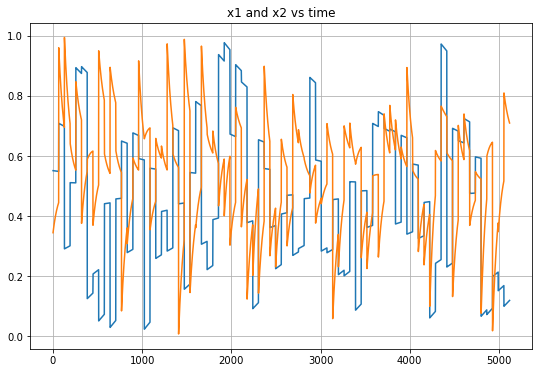

In [7]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

# Custom Model definition

## Encoder

In [8]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a encoder layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [9]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc1 = EncoderLayer(32)
        self.enc2 = EncoderLayer(64)
        self.enc3 = EncoderLayer(128)

    def call(self, input):
        x = input
        x = self.enc1(x)
        x = tf.nn.elu(x)
        x = self.enc2(x)
        x = tf.nn.elu(x)

        # Encoder output layer
        z = self.enc3(x)
        z = tf.nn.elu(z)
        return z

## Koopman

In [10]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 indices = tf.constant([[traj*self.trajLength]])
                 if m == 0: 
                     updates = [tf.linalg.matvec(self.K, z1[0,:])]
                     tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    updates = [tf.linalg.matvec(tf.matmul(self.K,self.K), z1[traj,:])]
                    tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                    
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [11]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    K: tensor
        Koopman operator in the lifted space
    """
    
    def __init__(self, trajLength, numTraj , name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

## Decoder

In [12]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [13]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    """
    
    def __init__(self, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec1 = DecoderLayer(64)
        self.dec2 = DecoderLayer(32)
        self.outputLayer = DecoderLayer(2)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.elu(z)
        z2_hat = tf.nn.elu(z2_hat)
        z2_tilde = tf.nn.elu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.elu(z)
        z2_hat = tf.nn.elu(z2_hat)
        z2_tilde = tf.nn.elu(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        x_hat = tf.nn.elu(x_hat)
        x2_hat = tf.nn.elu(x2_hat)
        x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

## Koopman Autoencoder

In [14]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    """
    
    def __init__(self, trajLength, numTraj , name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

# Custom Training Loop

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [31]:
class MyStaticModel():
    def __init__(self, input_dim, batch_size, trajLength):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 

    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 0.1
        alpha2 = 1e-7
        alpha3 = 1e-15

        x2 = []
        for i in range(self.numtraj_batch):
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength])
        x2 = tf.reshape(x2, [-1, x_train.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf),tf.subtract(x2,x2_hat))

        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)


    def graphPlot(self, error):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error)
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 

    
    def graphBatchLossPlot(self, epochNum, error):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error)
        textTitle = "BatchEpochHistoryLoss_%d_Trial_%d" % (epochNum, self.graphCounter)
        plt.title(textTitle)
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 


    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(1e-4)

        epochs = 10          
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                batch_train_loss = 0
                with tf.GradientTape() as tape:
                    reconstruction, prediction, linearity = model(x_batch_train)

                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                    
                # Log every 100 batches.
                if step % 1 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(batch_train_loss))
                    )
            
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/num_batches
            epoch_train_loss.append(avg_train_loss)

            print("Average training loss at epoch %d: %.4f"% (epoch, float(avg_train_loss)))
            print("Time taken: %.2fs" % (time.time() - start_time))
            print("Sum of Koopman Layer weights: %0.3f" % np.sum(model.koopman.get_weights()[0]))
        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, pred_val, linearity_val = model(x_batch_val)

                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/num_batches)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches}")
            print("Time taken: %.2fs" % (time.time() - start_time))
            self.graphBatchLossPlot(epoch, batch_train_loss_list)

        self.graphPlot(epoch_train_loss)


Start of epoch 0

Start of epoch 0
Training loss (for one batch) at step 0: 155.2495
Training loss (for one batch) at step 1: 154.7394
Training loss (for one batch) at step 2: 154.3801
Training loss (for one batch) at step 3: 154.4204
Training loss (for one batch) at step 4: 153.8458
Training loss (for one batch) at step 5: 153.6516
Training loss (for one batch) at step 6: 153.0575
Training loss (for one batch) at step 7: 153.4518
Training loss (for one batch) at step 8: 152.7467
Training loss (for one batch) at step 9: 152.2376
Average training loss at epoch 0: 153.7780
Time taken: 4.09s
Sum of Koopman Layer weights: 5.289
Epoch val loss: 152.28609619140624
Time taken: 7.49s
Tried making folder. Folder already exists...

Start of epoch 1

Start of epoch 1
Training loss (for one batch) at step 0: 152.5424
Training loss (for one batch) at step 1: 152.0399
Training loss (for one batch) at step 2: 151.6863
Training loss (for one batch) at step 3: 151.7266
Training loss (for one batch) at

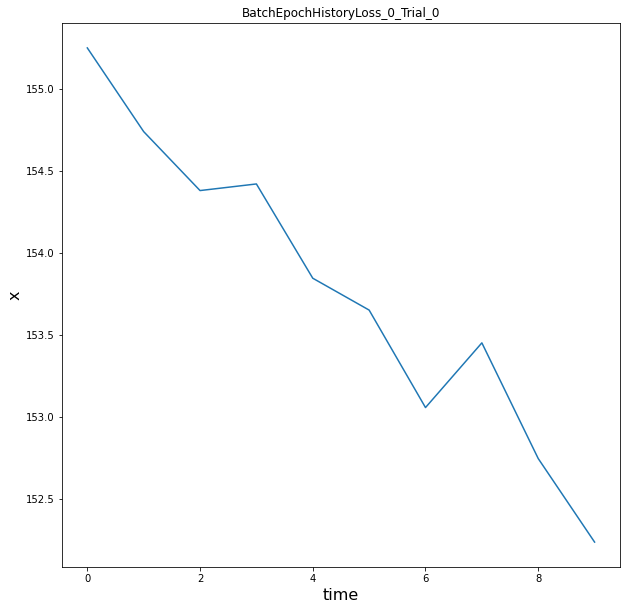

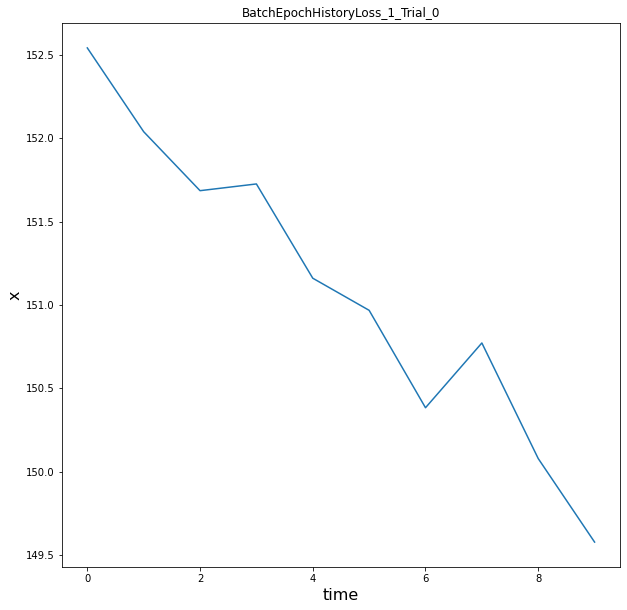

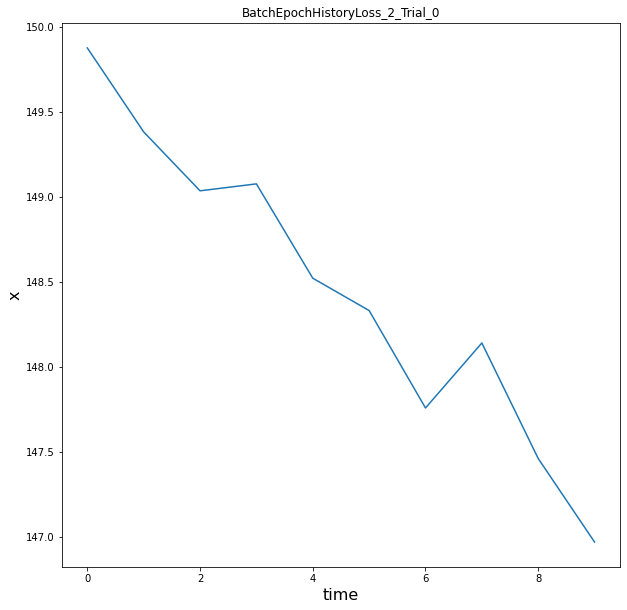

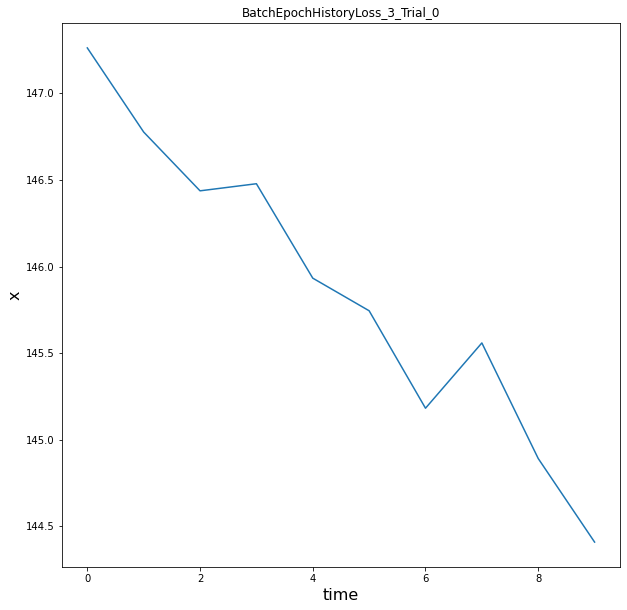

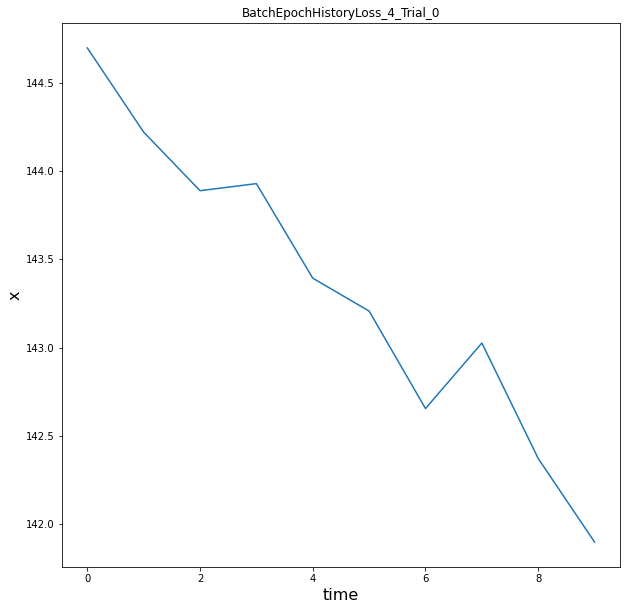

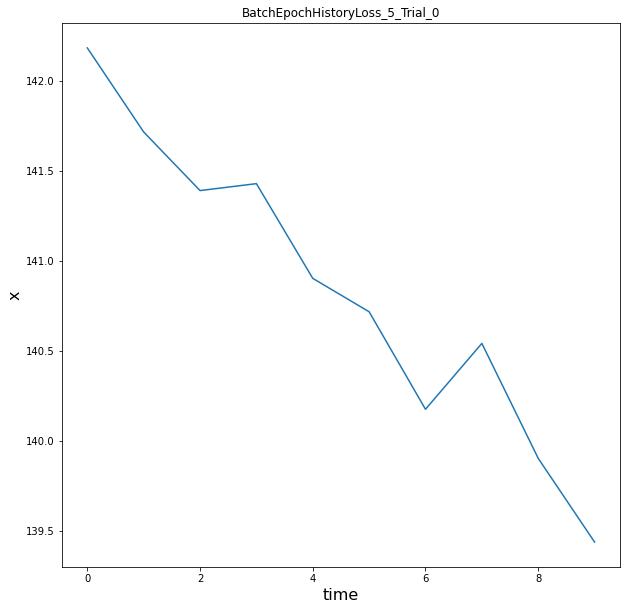

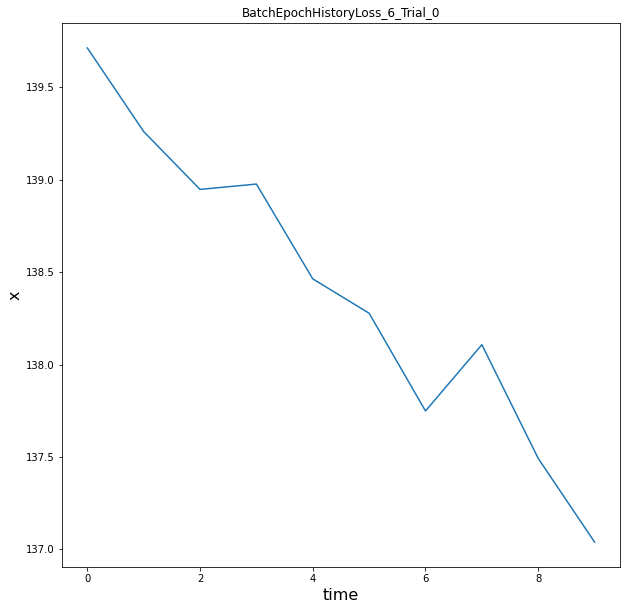

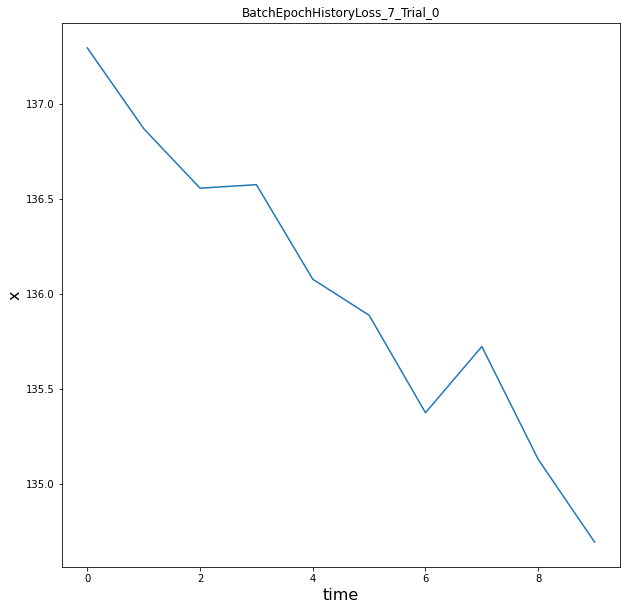

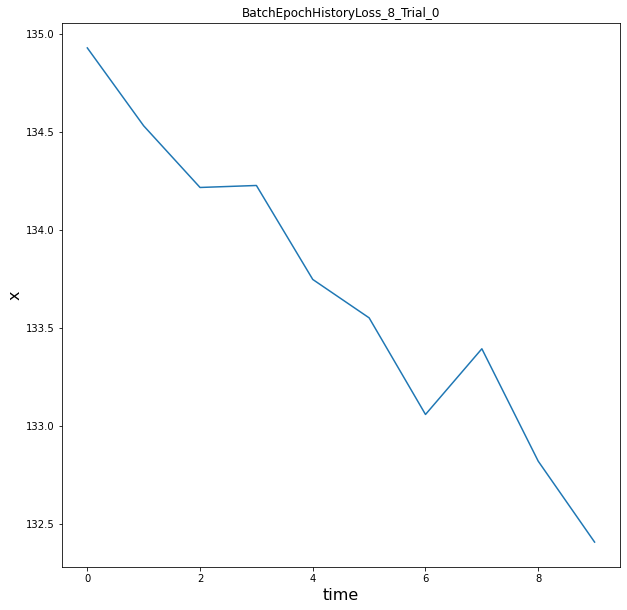

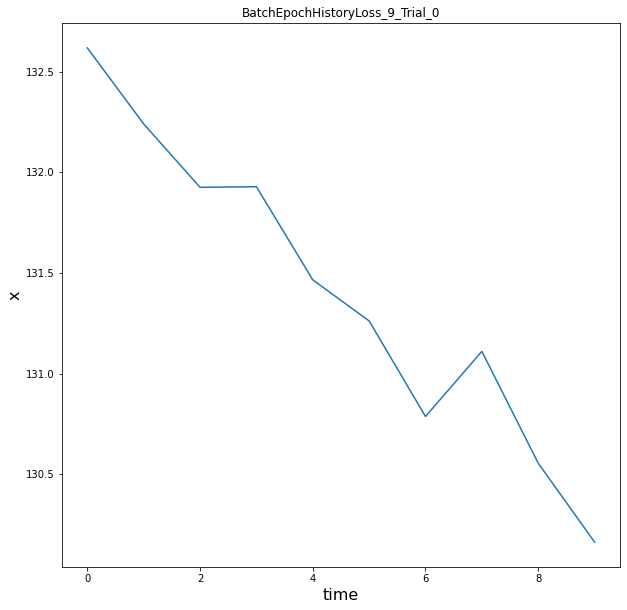

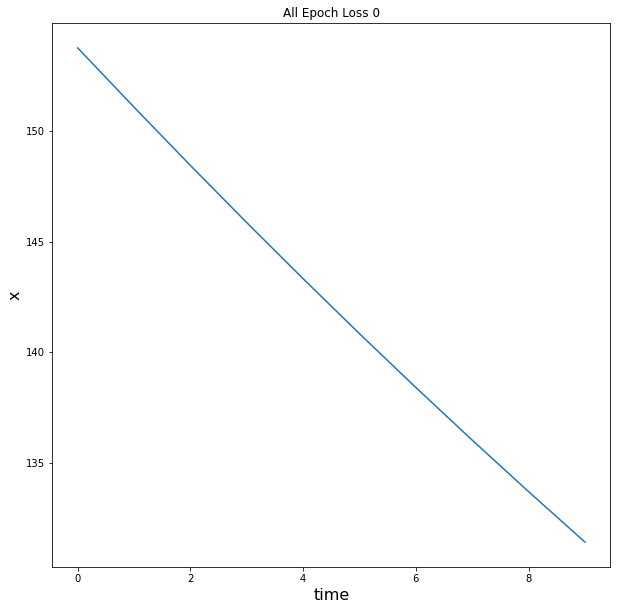

In [41]:
Training_class = MyStaticModel(input_dim, batch_size, trajLength)
koopmanAEModel = Koopman_AE_Model(trajLength, numTraj_batch, name="Koopman_AE_Model")
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)

# Plots

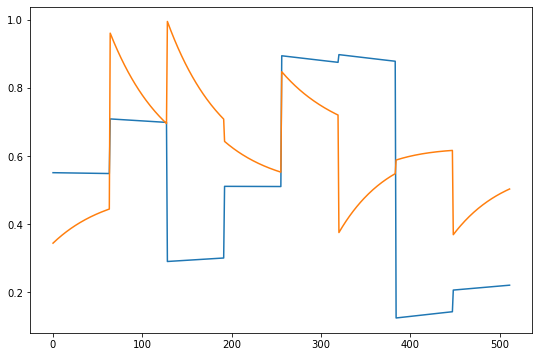

In [28]:
input = x_train[0:batch_size]
plt.plot(input)

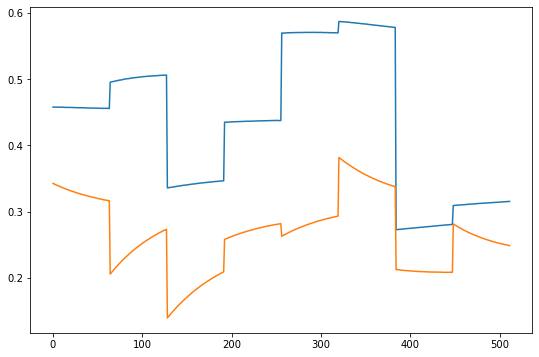

In [33]:
out1, out2, out3 = koopmanAEModel(input)
plt.plot(out1)

# Save the Model

In [34]:
koopmanAEModel.save('checkpoints/Static_koopman1')

INFO:tensorflow:Assets written to: checkpoints/Static_koopman1\assets


# Load the Model

In [35]:
new_model = tf.keras.models.load_model('checkpoints/Static_koopman1', compile=False)

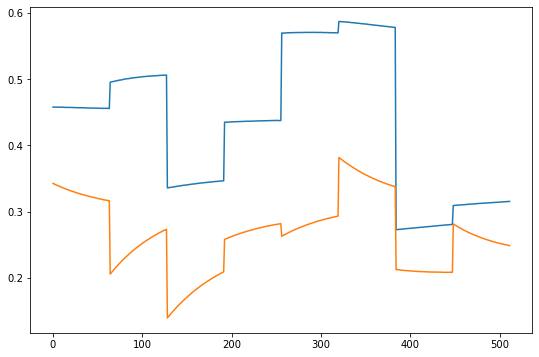

In [38]:
new_out1, new_out2, new_out2 = new_model(input)
plt.plot(new_out1)

In [39]:
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_4 (EncoderMode multiple                  10528     
_________________________________________________________________
koopman__model_4 (Koopman_Mo multiple                  16384     
_________________________________________________________________
decoder_model_4 (DecoderMode multiple                  10402     
Total params: 37,314
Trainable params: 37,314
Non-trainable params: 0
_________________________________________________________________


In [40]:
Z = new_model.enc(x_train)
K = new_model.koopman.get_weights()
K = np.squeeze(K)
print(K)

[[ 0.00330657 -0.02372306  0.00955736 ...  0.03539269  0.02490424
  -0.04920186]
 [-0.00614261  0.00177885 -0.00324578 ...  0.02941323  0.00132424
   0.01025594]
 [ 0.05234109  0.01765832  0.04569719 ...  0.00654773 -0.00929912
  -0.04190337]
 ...
 [-0.00965988 -0.00836896 -0.10952038 ... -0.05111505  0.03271779
  -0.03392745]
 [-0.0445093   0.00154014 -0.00861975 ... -0.06627637  0.12244771
  -0.00237461]
 [-0.01147488 -0.13278274  0.0054559  ...  0.00218887 -0.03165024
   0.04445763]]
